## Exploring data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import hydroeval as he
from tensorflow import keras
import hydroeval as he

In [185]:
# reading data
df_b = pd.read_csv("data/basel.csv", index_col=0)
df_b.tail()

,datetime,et,p,t,obs
7300,2000-12-27,0.000492,0.001242,2.119268,662.035
7301,2000-12-28,0.000413,0.000561,-0.594725,656.253
7302,2000-12-29,0.000348,0.002027,-3.251007,652.150
7303,2000-12-30,0.000306,0.000741,-5.414832,641.549
7304,2000-12-31,0.000274,0.000000,-7.274929,599.663


In [65]:
df_b.columns

Index(['datetime', 'et', 'p', 't', 'obs', 'date_ordinal'], dtype='object')

In [3]:
# inspecting data
df_b.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
et,7305.0,0.001714,0.001106,0.000174,0.000699,0.001463,0.002551,0.005657
p,7305.0,0.004003,0.006059,0.000000,0.000000,0.001118,0.005937,0.064737
t,7305.0,7.407180,7.137879,-21.928990,2.108310,7.466198,13.141790,25.095398
obs,7305.0,1089.771141,460.346002,393.000000,751.000000,1003.000000,1332.000000,4583.996000


In [165]:
q_basel = pd.read_csv("data/q_basel.csv")
q_basel = q_basel.drop(["obs"], axis =1)
# making date time the index of data
q_basel = q_basel.set_index("datetime")
q_basel

,pcr,res
datetime,,
1981-01-01,605.06915,64.93085
1981-01-02,599.35767,47.64233
1981-01-03,874.38354,-147.38354
1981-01-04,998.86804,364.13196
1981-01-05,968.06270,233.93730
...,...,...
2000-12-27,1055.62610,-393.59110
2000-12-28,1027.90730,-371.65430
2000-12-29,860.76306,-208.61306


In [166]:
# make the date column index
df_basel = df_b.set_index("datetime")
df_basel.shape

(7305, 4)

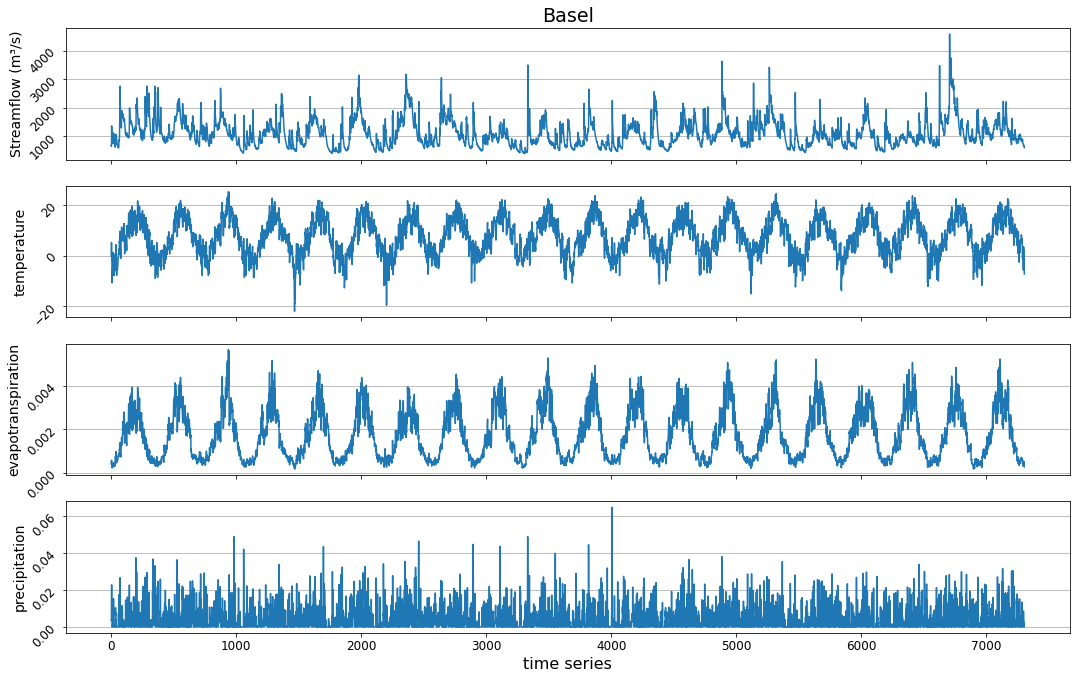

In [186]:
# plot data
shown_data = 0.5

# variables to plot
obs_b = df_basel.obs.values
t_b = df_basel.t.values
et_b = df_basel.et.values
p_b = df_basel.p.values


# plot the variables
plt.rcParams.update({'font.size': 16})

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(18, 18*2/(1+5**0.5)))
ax1.plot(obs_b)
ax2.plot(t_b)
ax3.plot(et_b)
ax4.plot(p_b)


#set the ticks
days_per_year = [0]+[365, 365, 365, 366]*5
ticks = np.cumsum(days_per_year[:-1])[:int(20*shown_data)]

#tweak the axes
ax1.title.set_text('Basel')
ax4.set_xlabel('time series')
ax1.set_ylabel('Streamflow (m³/s)', fontsize = 14)
ax2.set_ylabel('temperature', fontsize = 14)
ax3.set_ylabel('evapotranspiration', fontsize = 14)
ax4.set_ylabel('precipitation', fontsize = 14)

for ax in (ax1, ax2, ax3, ax4):
  ax.grid(axis = 'y')
  ax.tick_params(axis='y', labelsize=12,  rotation = 45)
  ax.tick_params(axis='x', labelsize=12)



## LSTM data prepration

In [7]:
# a function that, given the initial dataframe, return a shorter dataframe sequence of length.
from numpy.random import seed
seed(7)
def subsample_sequence(df, length):

    last_possible = df.shape[0] - length

    random_start = np.random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length]

    return df_sample

In [8]:
# a function to deal with nan values
def fillna(X, df_mean):

    na = X.mean()

    na.fillna(df_mean)
    return na

# a function that given a full dataframe, first subsample this dataset into a shorter sequence,
# and then splits the shorter dataframe into a training sequence and a value to predict.

def split_subsample_sequence(df, length, df_mean=None):
    # little trick to improve the time
    if df_mean is None:
        df_mean = df.mean()

    df_subsample = subsample_sequence(df, length)
    if set(["pcr","res"]).issubset(df_subsample.columns):
        y_sample = df_subsample.iloc[df_subsample.shape[0]-1]['pcr']
    else:
        y_sample = df_subsample.iloc[df_subsample.shape[0]-1]['obs']

    if y_sample != y_sample: # A value is not equal to itself only for NaN. So it will be True if y_sample is nan
        X_sample, y_sample = split_subsample_sequence(df, length, df_mean)
        return np.array(X_sample), np.array(y_sample)

    X_sample = df_subsample[0:df_subsample.shape[0]-1]
    X_sample = X_sample.fillna(fillna(X_sample, df_mean))
    X_sample = X_sample.values

    return np.array(X_sample), np.array(y_sample)

In [9]:
# another function that generates an entire dataset of multiple subsamples,
# given an initial dataframe df, a number of desired sequences, and a length for each sequence

def get_X_y(df, number_of_sequences, length):
    X, y = [], []

    for i in range(number_of_sequences):
        xi, yi = split_subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)

    X = np.array(X)
    y = np.array(y)

    return X, y

In [10]:
# train test split
len_ = int(0.75 *df_basel.shape[0])

df_train = df_basel[:len_]
df_test = df_basel[len_:]

In [11]:
# time window based on  insight gained from ccf function in R is equal to 50
from numpy.random import seed
seed(7)
X_train, y_train = get_X_y(df_train, 2000, 51) # the training set correspond to 2000 sequences, each of size 50 (+ the time to predict)
X_test, y_test = get_X_y(df_test, 731, 51)


In [12]:
# dropping "obs" var from predictors in train set
X_train_new = [np.delete(X,-1, axis =1) for X in X_train]
X_train_ready = np.asarray(X_train_new)
X_train_ready.shape

(2000, 50, 3)

In [13]:
# dropping "obs" var from predictors in test set
X_test_new = [np.delete(X,-1, axis = 1) for X in X_test]
X_test_ready = np.asarray(X_test_new)
X_test_ready.shape

(731, 50, 3)

## Normalizing data

In [14]:
# using min-max normalizing
# https://stackoverflow.com/questions/50125844/how-to-standard-scale-a-3d-matrix
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_ready.reshape(-1, X_train_ready.shape[-1])).reshape(X_train_ready.shape)
X_test_scaled = scaler.transform(X_test_ready.reshape(-1, X_test_ready.shape[-1])).reshape(X_test_ready.shape)


In [15]:
# normalize output
y_train_shaped = np.reshape(y_train, (y_train.shape[0], 1))

scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train_shaped)


y_test_shaped = np.reshape(y_test, (y_test.shape[0], 1))

y_test_scaled = scaler.transform(y_test_shaped)
y_test_scaled.shape

(731, 1)

## Hyperparameter Optimization

In [16]:
# SOME USEFUL LINKS
# https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53
# https://medium.com/analytics-vidhya/hypertuning-a-lstm-with-keras-tuner-to-forecast-solar-irradiance-7da7577e96eb
# https://www.kaggle.com/code/rendyk/neural-network-hyperparameter-tuning/notebook
# https://keras.io/keras_tuner/

In [17]:
import keras_tuner as kt
from tensorflow import keras


# define the baseline model
def build_baseline_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(y_train_scaled.shape[1], activation=hp.Choice('dense_activation',values=['relu', 'tanh'],default='relu')))
    model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[0.01, 0.001])), metrics = ['mse'])
    return model


In [18]:
# instantiate the Hyperband tuner
tuner = kt.Hyperband(build_baseline_model,
                     overwrite=True,
                     objective='mse',
                     max_epochs=20,
                     factor=3,
                     hyperband_iterations = 1,
                     directory='hyperparameter_tunning_2',
                     project_name='LSTM_Basel_hyperparameter_tunning')



In [19]:
# create a callback to stop training early after reaching a certain value for the validation loss.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

# run the tuner
tuner.search(X_train_scaled, y_train_scaled, epochs=25, validation_split=0.2, callbacks=[es])

# get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]


Trial 30 Complete [00h 17m 16s]
mse: 0.005862846504896879

Best mse So Far: 0.005862846504896879
Total elapsed time: 03h 16m 11s
INFO:tensorflow:Oracle triggered exit


In [29]:
print(tuner.results_summary())

Results summary
Results in hyperparameter_tunning_2\LSTM_Basel_hyperparameter_tunning
Showing 10 best trials
Trial summary
Hyperparameters:
input_unit: 384
n_layers: 3
lstm_0_units: 224
layer_2_neurons: 160
Dropout_rate: 0.1
dense_activation: tanh
learning_rate: 0.001
lstm_1_units: 416
lstm_2_units: 160
lstm_3_units: 160
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.005862846504896879
Trial summary
Hyperparameters:
input_unit: 128
n_layers: 3
lstm_0_units: 224
layer_2_neurons: 480
Dropout_rate: 0.2
dense_activation: relu
learning_rate: 0.001
lstm_1_units: 320
lstm_2_units: 288
lstm_3_units: 320
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.005873263347893953
Trial summary
Hyperparameters:
input_unit: 448
n_layers: 2
lstm_0_units: 96
layer_2_neurons: 352
Dropout_rate: 0.1
dense_activation: tanh
learning_rate: 0.001
lstm_1_units: 128
lstm_2_units: 160
lstm_3_units: 224
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/brac

In [33]:
# geeting optimal params in a dict to save it
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

# reading optimal params in a df
dict_ = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
lstm_best_params = pd.DataFrame([dict_])
lstm_best_params

,input_unit,n_layers,lstm_0_units,layer_2_neurons,Dropout_rate,dense_activation,learning_rate,lstm_1_units,lstm_2_units,lstm_3_units,tuner/epochs,tuner/initial_epoch,tuner/bracket,tuner/round
0,384,3,224,160,0.1,tanh,0.001,416,160,160,20,0,0,0


In [34]:
# saving the optimal param in a csv
## commented out the line to prevent saving again when you run the code ##
# lstm_best_params.to_csv('lstm_best_params.csv', index=False)

## Single Model Run

In [35]:
%%time

# building the model based on optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# create a callback to stop training early after reaching a certain value for the validation loss.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

# run the model
history = model.fit(X_train_scaled, y_train_scaled,
            validation_split= 0.2,
            epochs=1000,
            batch_size= 32, # tried it with 16 | 128  | 512
            callbacks=[es])

Epoch 1/1000
50/50 [==============================] - 82s 1s/step - loss: 0.0222 - mse: 0.0222 - val_loss: 0.0199 - val_mse: 0.0199
Epoch 2/1000
50/50 [==============================] - 63s 1s/step - loss: 0.0151 - mse: 0.0151 - val_loss: 0.0180 - val_mse: 0.0180
Epoch 3/1000
50/50 [==============================] - 61s 1s/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0159 - val_mse: 0.0159
Epoch 4/1000
50/50 [==============================] - 59s 1s/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 5/1000
50/50 [==============================] - 57s 1s/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 6/1000
50/50 [==============================] - 59s 1s/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 7/1000
50/50 [==============================] - 61s 1s/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 8/1000
50/50 [==============================] - 67s 1s/step - loss: 0.

In [36]:
# summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50, 384)           595968    
                                                                 
 lstm_6 (LSTM)               (None, 50, 224)           545664    
                                                                 
 lstm_7 (LSTM)               (None, 50, 416)           1066624   
                                                                 
 lstm_8 (LSTM)               (None, 50, 160)           369280    
                                                                 
 lstm_9 (LSTM)               (None, 160)               205440    
                                                                 
 dropout_1 (Dropout)         (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                

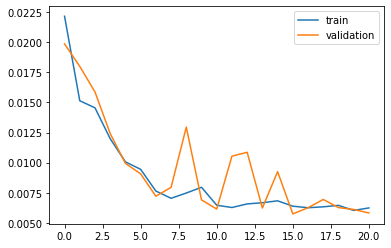

In [37]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

# why test loss is less than train loss: https://www.researchgate.net/post/Tuning_hyperparameters_for_LSTM_Neural_Network

# Evaluation

In [38]:
# mse evaluation
res = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)

print(f'MSE on the test set : {res[1]:.4f}')

MSE on the test set : 0.0066


In [39]:
# nse evaluation
y_pred = model.predict(X_test_scaled)

nse = he.evaluator(he.nse,y_pred,y_test_scaled)
nse[0]

0.7144279340700626

In [40]:
# kge evaluation
kge = he.evaluator(he.kge, y_pred, y_test_scaled)
kge[0]

array([0.76970296])

# Saving Model

In [41]:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model_2.h5")
print("Saved model to disk")

Saved model to disk


In [42]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_2.h5")
print("Loaded model from disk")

Loaded model from disk


In [43]:
# evaluate loaded model on test data
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loaded_model.compile(loss='mean_squared_error',optimizer= optimizer , metrics = ['mse'])
score = loaded_model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f'MSE on the test set : {res[1]:.4f}')

MSE on the test set : 0.0066


## Ensemble Runs

In [ ]:
# useful links
# How to Train a Final Machine Learning Model:  https://machinelearningmastery.com/train-final-machine-learning-model/

In [44]:
%%time

# define a function to run the model multiple times
def train_multiple_times():
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
    model.fit(X_train_scaled, y_train_scaled,
            validation_split=0.2,
            epochs=1000,
            batch_size= 32,
            callbacks=[es])
    y_pred = model.predict(X_test_scaled)
    # invert predictions
    y_pred_inversed = scaler.inverse_transform(y_pred)


    nse = he.evaluator(he.nse,y_pred,y_test_scaled)
    kge = he.evaluator(he.kge, y_pred, y_test_scaled)
    return (nse, kge[0], y_pred_inversed)


nse = []
kge = []
y_pred = []
repeats = 10

# a for loop for running model 10 times
for t in range(repeats):

    nse_multiple, kge_multiple, y_pred_inversed = train_multiple_times()
    nse.append(nse_multiple)
    kge.append(kge_multiple)
    y_pred.append(y_pred_inversed)

    print(f'For {t} time running model, the NSE is : {nse_multiple}')
    print(f'For {t} time running model, the KGE is : {kge_multiple}')

Epoch 1/1000
50/50 [==============================] - 58s 1s/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 2/1000
50/50 [==============================] - 56s 1s/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 3/1000
50/50 [==============================] - 56s 1s/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 4/1000
50/50 [==============================] - 57s 1s/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 5/1000
50/50 [==============================] - 61s 1s/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 6/1000
50/50 [==============================] - 53s 1s/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 7/1000
50/50 [==============================] - 54s 1s/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 7: early stopping
For 0 time running model, the NSE is : [0.67842828]


In [45]:
# convert y_pred to an array
y_pred_array = np.array(y_pred)

# dimension of y_pred array
y_pred_array.shape

(10, 731, 1)

In [46]:
# taking the mean of y_preds over 10 time predictions and saving it in a csv file
y_df = pd.DataFrame(y_pred_array.mean(axis=0))

# changing the name of the column
y_df.columns = ["y_pred"]

# saving the calculated mean to a csv file
y_df.to_csv("predicted/y_pred_lstm_10.csv")

In [47]:
# double-check the mean of y_pred with another technique
np.save("predicted/y_pred_lstm_10.npy", y_pred_array, allow_pickle=True)
y_pred_loaded = np.load('predicted/y_pred_lstm_10.npy', allow_pickle=True)
y_pred_loaded.shape

(10, 731, 1)

In [49]:
# save NSE

nse = np.array(nse)
np.save('predicted/nse_basel_ave_10.npy', nse, allow_pickle=True)

# best so far is nse_basel_3
nse_loaded = np.load('predicted/nse_basel_ave_10.npy',allow_pickle=True)

# means and sd of NSE
nse_mean = np.mean(nse_loaded)
nse_sd = np.std(nse_loaded)
print(f'mean NSE is : {nse_mean}')
print(f'Standard devation of NSE over 10 times running model is : {nse_sd}')

mean NSE is : 0.6938660788206008
Standard devation of NSE over 10 times running model is : 0.018014171056534387


In [50]:
# save KGE

kge = np.array(kge)
np.save('predicted/kge_basel_ave_10.npy', kge, allow_pickle=True)

kge_loaded = np.load('predicted/kge_basel_ave_10.npy',allow_pickle=True)

# means and sd of KGE
kge_mean = np.mean(kge_loaded)
kge_sd = np.std(kge_loaded)
print(f'mean KGE is : {kge_mean}')
print(f'Standard deviation of KGE over 10 times running model is : {kge_sd}')

mean KGE is : 0.7594008223570434
Standard deviation of KGE over 10 times running model is : 0.03765438399077669


## Prediction

In [270]:
# useful link : https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba
Y_df = pd.read_csv("predicted/y_pred_lstm_10.csv",index_col=0)
Y_pred = Y_df.y_pred.values


In [271]:
# add date of prediction
Y_df['date'] = pd.date_range(start = "1/1/1999", periods =731, freq = "D")
Y_df

,y_pred,date
0,616.65027,1999-01-01
1,1214.29960,1999-01-02
2,679.45810,1999-01-03
3,993.90380,1999-01-04
4,1226.62010,1999-01-05
...,...,...
726,813.71857,2000-12-27
727,1126.40730,2000-12-28
728,695.93220,2000-12-29
729,849.10706,2000-12-30


# PCR

In [245]:
# getting the result of pcr model
pcr_pred = q_basel.pcr.values[len_:]

# train-test split
len_ = int(0.75*q_basel.shape[0])

df_train_pcr = q_basel[:len_]
df_test_pcr = q_basel[len_:]

# making data in right shape
pcr_X_train, pcr_y_train = get_X_y(df_train_pcr, 2000, 51)
pcr_X_test, pcr_y_test = get_X_y(df_test_pcr, 731, 51)

# normalize pcr_observation
pcr_y_test_reshaped = np.reshape(pcr_y_test, (pcr_y_test.shape[0], 1))

scaler = MinMaxScaler()
pcr_y_test_scaled = scaler.fit_transform(pcr_y_test_reshaped)

# nse for pcr
nse_pcr = he.evaluator(he.nse, pcr_y_test_scaled, y_test_scaled)

## Plots

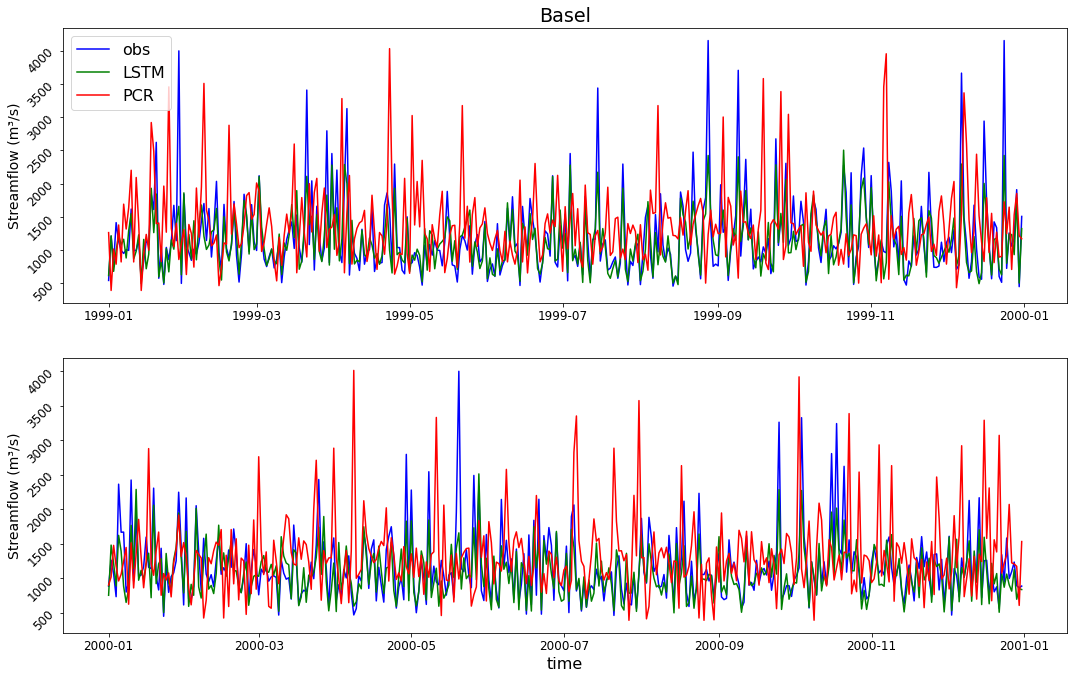

In [272]:
# plot performance of model for year 1999-2000 and 2000-2001 in two different subplots

# variables to plot
Y_test = scaler.inverse_transform(y_test_scaled)
predicted = Y_df.y_pred
pcr_prediction = pcr_y_test

date = Y_df.date

# years to plot
date_1 = Y_df.date[:365]

date_2 = Y_df.date[365:]

# dividing variables to two years
actual_1 = Y_test[:365]
actual_2 = Y_test[365:]

predicted_1 = Y_df.y_pred[:365]
predicted_2 = Y_df.y_pred[365:]


pcr_prediction_1 = pcr_y_test[:365]
pcr_prediction_2 = pcr_y_test[365:]


# plot the variables
plt.rcParams.update({'font.size': 16})

fig, (ax1, ax2) = plt.subplots(2, sharex=False, figsize=(18, 18*2/(1+5**0.5)))

# ax1.plot(date, Y_test, "b",date, predicted, "g", date, pcr_prediction, "r")



ax1.plot(date_1, actual_1, "b",label ="obs")
ax1.plot(date_1, predicted_1, "g", label = "LSTM")
ax1.plot(date_1, pcr_prediction_1,"r", label = "PCR")

ax2.plot(date_2, actual_2,"b", date_2, predicted_2,"g", date_2, pcr_prediction_2, "r")

#set the ticks
days_per_year = [0]+[365, 365, 365, 366]*5
ticks = np.cumsum(days_per_year[:-1])[:int(20*shown_data)]

#tweak the axes
ax1.title.set_text('Basel')
ax2.set_xlabel('time')
ax1.set_ylabel('Streamflow (m³/s)', fontsize = 14) # maybe change the range of y axis so that you do not see so many variation 
ax2.set_ylabel('Streamflow (m³/s)', fontsize = 14)
ax1.legend()

for ax in (ax1, ax2):
  #ax.grid(axis = 'y')
  ax.tick_params(axis='y', labelsize=12,  rotation = 45)
  ax.tick_params(axis='x', labelsize=12)



plt.savefig("figures/1999-2000_plot.png")

In [261]:
# https://stackoverflow.com/questions/9834452/how-do-i-make-a-single-legend-for-many-subplots-with-matplotlib
len(Y_df.y_pred)

TypeError: 'int' object is not callable

In [268]:
#define a smoothing function
def smooth_fun(y, window):
  new_lenth = len(y)//window
  smooth_y = np.zeros((new_lenth))
  for i in range(new_lenth):
    smooth_y[i] = np.mean(y[i*window:i*window+window])
  return smooth_y

In [273]:
# to do: change the type of Y_test and Y_pred ... to numpy array and see if smooth function works 
# set time window for smoothing and the number of ticks in the plot
window = 14
nticks = 8

date = Y_df.date
# years to plot
date_1 = Y_df.date[:365]

date_2 = Y_df.date[365:]

# dividing variables to two years
actual_1 = Y_test[:365]
# actual_1 = smooth_fun(actual_1, window)
# actual_1
# actual_2 = Y_test[365:]
#
# predicted_1 = Y_df.y_pred[:365]
predicted_1 = smooth_fun(predicted_1,window)
predicted_1
# predicted_2 = Y_df.y_pred[365:]
#
#
# pcr_prediction_1 = pcr_y_test[:365]
# pcr_prediction_2 = pcr_y_test[365:]
#
# date_1 = Y_df.date[:365]
#
# date_2 = Y_df.date[365:]
#
# # plot the variables
# plt.rcParams.update({'font.size': 16})
#
# fig, (ax1, ax2) = plt.subplots(2, sharex=False, figsize=(18, 18*2/(1+5**0.5)))
#
# # ax1.plot(date, Y_test, "b",date, predicted, "g", date, pcr_prediction, "r")
#
# ax1.plot(date_1, actual_1, "b",date_1, smooth_fun(predicted_1,window), "g",  date_1, smooth_fun(pcr_prediction_1,window),"r") # how to give label for each line?
#
# ax2.plot(date_2, smooth_fun(actual_2,window), "b", date_2, smooth_fun(predicted_2,window),"g", date_2, smooth_fun(pcr_prediction_2,window), "r")
#
#
# #set the ticks
# #configure axis
# plt.xticks(np.arange(0, len(predicted_1)//window +1, len(predicted_1)//(window*(nticks-1))),
#            date[np.arange(0, len(predicted_1) + 1, len(predicted_1)//(nticks-1))],
#            fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.xlabel('Date', fontsize = 16)
# plt.ylabel('Streamflow (m³/s)', fontsize = 16)
#
# #tweak the axes
# ax1.title.set_text('Basel')
# ax2.set_xlabel('time')
# ax1.set_ylabel('Streamflow (m³/s)', fontsize = 14)
# ax2.set_ylabel('Streamflow (m³/s)', fontsize = 14)
#
# for ax in (ax1, ax2):
#   #ax.grid(axis = 'y')
#   ax.tick_params(axis='y', labelsize=12,  rotation = 45)
#   ax.tick_params(axis='x', labelsize=12)
#
# plt.savefig("figures/1999-2000_plot.png")


TypeError: 'int' object is not callable

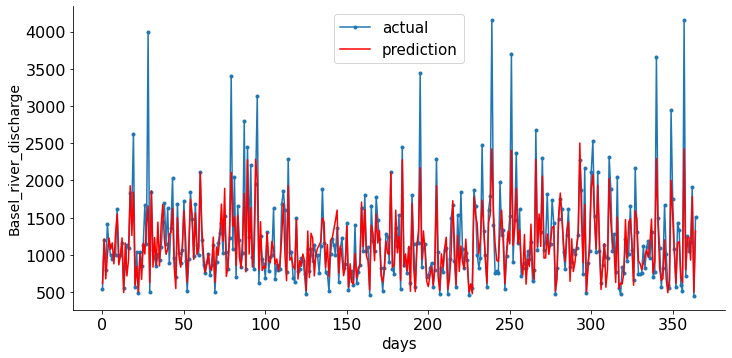

In [247]:
# comparing actual and predicted values for the last 356 days
import seaborn as sns
aa=[x for x in range(365)]
plt.figure(figsize=(10,5))
plt.plot(aa, Y_test[:365], marker='.', label="actual")
plt.plot(aa, Y_pred[:365], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Basel_river_discharge', size=14)
plt.xlabel('days', size=15)
plt.legend(fontsize=15)
plt.show();

In [147]:
#df_b["datetime"] =pd.to_datetime(df_b["datetime"])
df_b["datetime"] =df_b["datetime"].astype("string")
dates = df_b.datetime[-731:]
dates

6574    1999-01-01
6575    1999-01-02
6576    1999-01-03
6577    1999-01-04
6578    1999-01-05
           ...    
7300    2000-12-27
7301    2000-12-28
7302    2000-12-29
7303    2000-12-30
7304    2000-12-31
Name: datetime, Length: 731, dtype: string

KeyError: "None of [Int64Index([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,\n            260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500,\n            520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720],\n           dtype='int64')] are in the [index]"

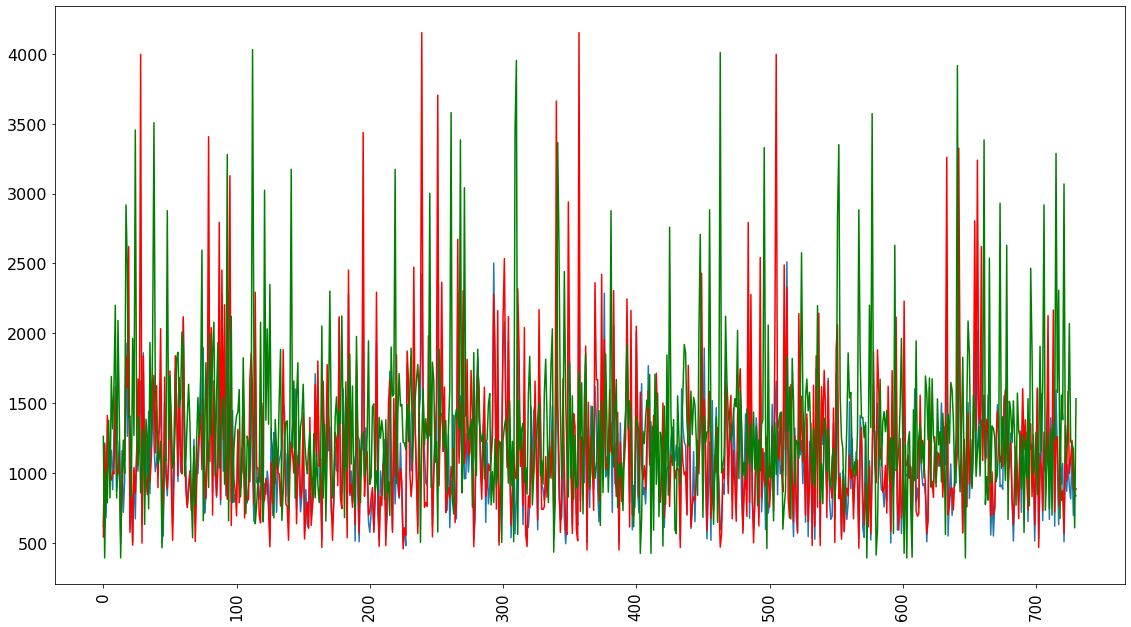

In [248]:
# plot prediction for the last 5 years with date as x axis
# how can you get prediction for the whole 5 years?

# make it an np data
dates = df_b.datetime[-731:]

plt.figure(figsize=(16,9))
plt.plot(Y_pred, label ="prediction")
plt.plot(Y_test, "r", label ="actual")
plt.plot(pcr_y_test,"green", label ="PCR")

# configure axis
plt.tick_params(axis='x',labelsize=15,rotation=90)
plt.tight_layout()
plt.xticks(np.arange(0, 731, 20), dates[np.arange(0, 731,20)], fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Streamflow (m³/s)', fontsize = 16)

plt.legend(prop={'size': 15})
plt.show()


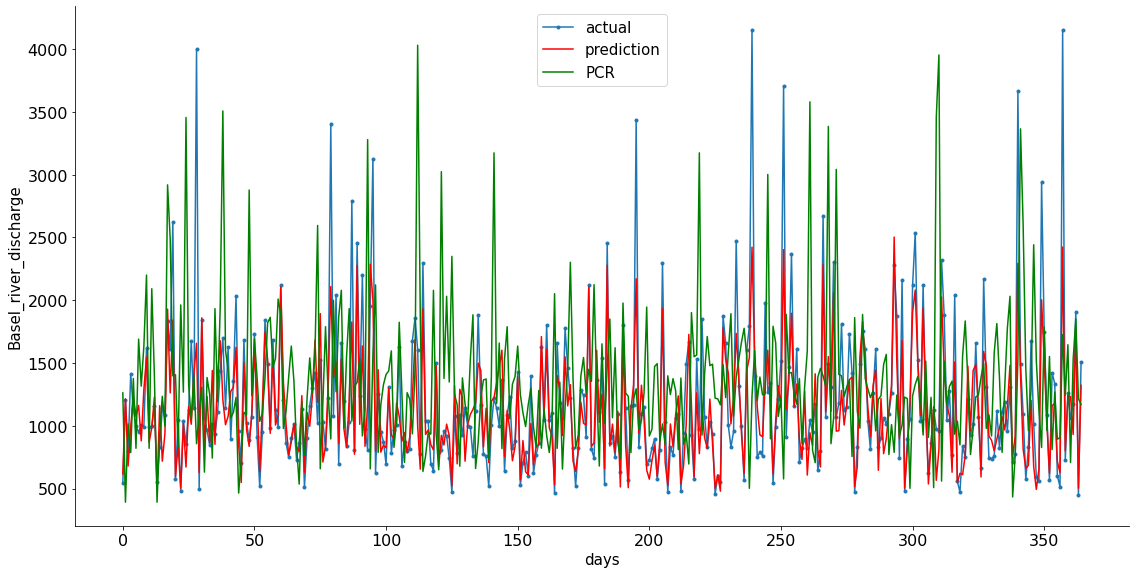

In [249]:
aa=[x for x in range(365)]
plt.figure(figsize=(16,8))
plt.plot(aa, Y_test[:365], marker='.', label="actual")
plt.plot(aa, Y_pred[:365], 'r', label="prediction")
plt.plot(aa, pcr_y_test [:365], "green", label ="PCR" )
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Basel_river_discharge', size=15)
plt.xlabel('days', size=15)
plt.legend(fontsize=15)
plt.show();

In [250]:
#define a smoothing function
def smooth_fun(y, window):
  new_len = len(y)//window
  smooth_y = np.zeros((new_len))
  for i in range(new_len):
    smooth_y[i] = np.mean(y[i*window:i*window+window])
  return smooth_y

In [252]:
# plot smoothed predictions
# prediction every 10 days
# this worked before: it means the type of 
plt.figure(figsize = (16,9))
plt.plot(smooth_fun(Y_test, 10),marker='.', label = "actual")
plt.plot(smooth_fun(predicted, 10),"r", label = "prediction")
plt.plot(smooth_fun(pcr_y_test,10),"g", label = "PCR")
plt.ylabel('Basel_river_discharge', size=15)
plt.xlabel('days', size=15)
sns.despine(top=True)
# plt.subplots_adjust(left=0.07)

plt.legend()
plt.show()

TypeError: 'int' object is not callable

<Figure size 1152x648 with 0 Axes>

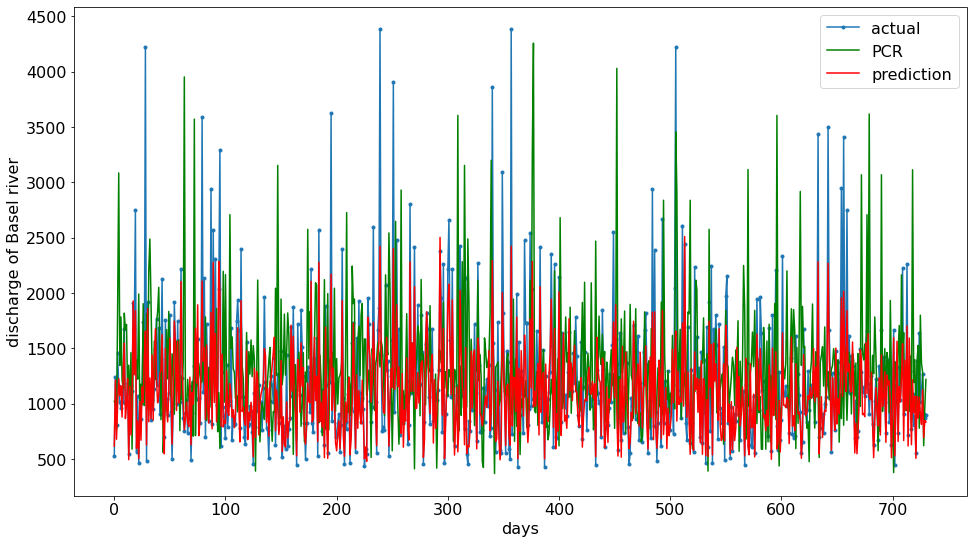

In [241]:
# make a plot of observed dicharge, prediction of model, prediction of pcr for the last 2 years
plt.figure(figsize=(16,9))
plt.plot(Y_test[:731], marker='.', label="actual")
plt.plot(pcr_y_test [:731], 'green', label="PCR")
plt.plot(Y_pred, 'r', label="prediction")
plt.xlabel('days')
plt.ylabel('discharge of Basel river')
plt.legend()

# Copy Weights for different batch size

In [ ]:
# Useful links:
# https://stackoverflow.com/questions/43702481/why-does-keras-lstm-batch-size-used-for-prediction-have-to-be-the-same-as-fittin :Why does Keras LSTM batch size used for prediction have to be the same as fitting batch size?

In [171]:
# re-define the batch size for 5 years of test set
from numpy.random import seed
seed(7)
X_train_, y_train_ = get_X_y(df_train, 2000, 51) # the training set correspond to 2000 sequences, each of size 50 (+ the time to predict)
X_test_, y_test_ = get_X_y(df_test, 1825, 51)

In [172]:
# dropping "obs" var from predictors in train set
X_train_ = [np.delete(X,-1, axis =1) for X in X_train_]
X_train_ready_ = np.asarray(X_train_)
# dropping "obs" var from predictors in test set
X_test_ = [np.delete(X,-1, axis = 1) for X in X_test_]
X_test_ready_ = np.asarray(X_test_)

# normalising
scaler = MinMaxScaler()
X_train_scaled_ = scaler.fit_transform(X_train_ready_.reshape(-1, X_train_ready_.shape[-1])).reshape(X_train_ready_.shape)
X_test_scaled_ = scaler.transform(X_test_ready_.reshape(-1, X_test_ready_.shape[-1])).reshape(X_test_ready_.shape)

# normalize output
y_train_shaped_ = np.reshape(y_train_, (y_train_.shape[0], 1))

scaler = MinMaxScaler()
y_train_scaled_ = scaler.fit_transform(y_train_shaped_)

y_test_shaped_ = np.reshape(y_test_, (y_test_.shape[0], 1))

y_test_scaled_ = scaler.transform(y_test_shaped_)


In [173]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_2.h5")

# evaluate loaded model on test data
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loaded_model.compile(loss='mean_squared_error',optimizer= optimizer , metrics = ['mse'])
score = loaded_model.evaluate(X_test_scaled_, y_test_scaled_, verbose=0)
#print(f'MSE on the test set : {res[1]:.4f}')

# nse evaluation
y_pred_ = loaded_model.predict(X_test_scaled_)

nse = he.evaluator(he.nse, y_pred_, y_test_scaled_)
nse[0]


0.7160110243437829

## A random model

In [106]:
%%time
# from numpy.random import seed
# seed(1)
# tf.random.set_seed(1234)

def init_model():

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True)) # input shape?? input_shape =(X_train_scaled.shape[1],3)
    model.add(Dropout(0.2)) # decrease this
    model.add(LSTM(50, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1,activation='linear')) # activation = linear

    optimizer = keras.optimizers.Adam(learning_rate=0.0001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mse'])

    return model



model = init_model()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train_scaled,
            validation_split=0.2,
            epochs=1000,
            batch_size= 32, # try it with 16| 128 = 0.0687 | 512 = 0.705
            callbacks=[es])

Epoch 1/1000
50/50 [==============================] - 15s 157ms/step - loss: 0.0533 - mse: 0.0533 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 2/1000
50/50 [==============================] - 7s 134ms/step - loss: 0.0230 - mse: 0.0230 - val_loss: 0.0220 - val_mse: 0.0220
Epoch 3/1000
50/50 [==============================] - 6s 125ms/step - loss: 0.0212 - mse: 0.0212 - val_loss: 0.0208 - val_mse: 0.0208
Epoch 4/1000
50/50 [==============================] - 6s 127ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0205 - val_mse: 0.0205
Epoch 5/1000
50/50 [==============================] - 7s 134ms/step - loss: 0.0200 - mse: 0.0200 - val_loss: 0.0197 - val_mse: 0.0197
Epoch 6/1000
50/50 [==============================] - 7s 145ms/step - loss: 0.0199 - mse: 0.0199 - val_loss: 0.0193 - val_mse: 0.0193
Epoch 7/1000
50/50 [==============================] - 7s 147ms/step - loss: 0.0189 - mse: 0.0189 - val_loss: 0.0182 - val_mse: 0.0182
Epoch 8/1000
50/50 [==============================] - 7s 145m

In [108]:
print(model.input_shape, model.output_shape) # None is a placeholder of batch size

(None, 50, 3) (None, 1)


In [109]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50, 50)            10800     
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_3 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_8 (LSTM)               (None, 50)               

## Evaluation

In [110]:
res = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)

print(f'MSE on the test set : {res[1]:.4f}')

MSE on the test set : 0.0125


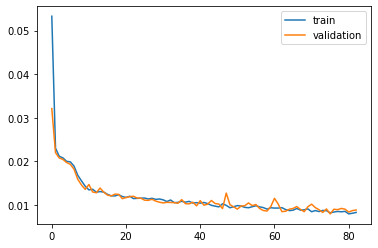

In [111]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

In [112]:

y_pred = model.predict(X_test_scaled)

nse = he.evaluator(he.nse,y_pred,y_test_scaled)
nse[0]


0.5714193210091113

In [113]:
# How to Train a Final Machine Learning Model:  https://machinelearningmastery.com/train-final-machine-learning-model/
kge = he.evaluator(he.kge, y_pred, y_test_scaled)
kge[0]

array([0.57987308])